# IOT Predictive Analytics with Bosch Production Line Performance Dataset 

## 1. Introduction

The Bosch Production Line Performance (PLP) dataset represents measurements of parts moving through production lines

The  data consists of large number of  anonymized features of various parts

Each part has a unique Id. The Response variable value decides the quality control outcome of the part

Features represented as Lxx_Sxxx_Fxxxx 
E.g. L3_S50_F4245. Feature number 4245 measured in line 3, station 50

Data is organized into separate files by feature type – numerical, categorical and date

Date feature provide timestamp when the feature was taken – viz, L0_S0_D1 is the time when the L0_S0_F0 was taken

The data is organized into the following files for train and test:

train_numeric.csv & test_numeric.csv - the training and test set numeric features

train_categorical.csv & test_categorical.csv - the training and test set categorical features

train_date.csv & test _date.csv - the training and test set date features

In the current example, the numeric data is considered to demonstrate the usage of various models 

Approach:
    - Data Loading and Exploratory analysis
    - Data Split into Train and Inference
    - Feature selection
    - Model Training and Inference

### 1.1 Importing Libraries

In [8]:
#Importing the required libraries

from __future__ import division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import itertools
# estimator imports
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# feature manipulation and preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction import DictVectorizer

# sampling, grid search, and reporting
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

%matplotlib inline

### 1.2 User Defined Functions

In [12]:
def evaluate_nans(df, axis=1, method="all"):
    """
    This function evaluates the presence of Nulls in the data
    """
    methods = {
        "all": lambda x: np.all(x),
        "some": lambda x: np.any(x)
    }
    
    if axis == 1:
        return [col for col in df.columns if methods[method](df[col].isnull())]
    
    return [row for row in df.index if methods[method](df.iloc[row][1:-1].isnull())]

In [13]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix
    """
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
def plot_roc_curve(classifier_name, test, pred):
    """
    This function prints and plots the RoC curve
    """
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    #print("x train lengths: %s" % len(X_train))
    plt.title("ROC curve for %s" % classifier_name)
    plt.plot(fpr,tpr,"b",label='AUC=%0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

<br>

## 2. Data Loading and Exploratory Analysis

- The dataset is loaded into memory using Pandas
- The total dataset consists of ~1.18 million records
- Of this to run locally a partial dataset is being loaded into a dataframe from the input datafile

### 2.1 Data Loading 

In [15]:
# To load the complete dataset into memory use the below call 
#df_numeric = pd.read_csv("data/bosch/train_numeric.csv")

# for running on the desktop use the below call. This would load partial data into memory
df_numeric = pd.read_csv("data/bosch/train_numeric.csv", nrows=100000)

In [16]:
print("number of records: %s" % len(df_numeric))
print("number of columns: %s" % len(df_numeric.columns))

number of records: 100000
number of columns: 970


In [17]:
feature_count = list(set(df_numeric.columns) - set(["Id", "Response"]))
print("number of features: %s" % len(feature_count))

number of features: 968


In [18]:
df_numeric.head(10)

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,13,0.003,0.019,0.294,0.312,0.031,0.161,0.022,0.088,-0.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,18,-0.016,-0.041,-0.179,-0.179,-0.056,0.161,-0.007,-0.032,-0.082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [19]:
# print the response column
df_numeric.iloc[:, -1:].head()

,Response
0,0
1,0
2,0
3,0
4,0


### 2.2 Exploratory Data Analysis   

In this section, the analysis is performed on the data. From the output of the head() command above it is evident there are  
significant number of nulls in the data. It requires to check how many features(data fields) have complete or partiall null value. A null value in a data field signified nothing. A feature with complete null values cannot contribute for the prediction. Those features can be removed from the dataset. For features where there are partial null data fields, data imputation has to be done with a mean value so thatit makes a reasonable data set that can be used to build the model.

In [21]:
# check the class representation in the dataset
df_numeric.loc[:, ['Id', 'Response']].groupby(['Response']).count()

,Id
Response,
0,99432
1,568


#### Proportions convey that there is a class imbalance with the positive class (i.e. failed parts) is underepresented.  

In [30]:
# Find all the feature data fields that have strictly not a number (nan) values
print("features with complete nan data fields: %s" % len(evaluate_nans(df_numeric, axis=1)))

features with complete nan data fields: 0


In [31]:
# Find all the feature data fields that have partially not a number (nan) values
print("features with partial nan data fields: %s" % len(evaluate_nans(df_numeric, axis=1, method="some")))

features with partial nan data fields: 968


In [36]:
# feature imputation methods prior to using models 

In [37]:
df_numeric.fillna(df_numeric.mean(), inplace=True)

In [38]:
df_numeric_mean = df_numeric

In [39]:
# split numerical data into training and test sets - 70/30

In [40]:
features = list(set(df_numeric_mean.columns) - set(["Id", "Response"]))

#### Split the entire dataset as Independent X(feature data) and Dependent y(Response) variables

In [41]:
X = df_numeric_mean[features].values
y = df_numeric_mean["Response"].values

## 3. Data Preparation

### 3.1 Data split into Train and Inference(Test)

In [42]:
X_train = X[:int(0.7*len(X))]
X_test = X[int(0.7*len(X)):]
y_train = y[:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]

In [23]:
print("x train lengths: %s" % len(X_train))
print("x test lengths: %s" % len(X_test))
print("y train lengths: %s" % len(y_train))
print("y test lengths: %s" % len(y_test))

x train lengths: 70000
x test lengths: 30000
y train lengths: 70000
y test lengths: 30000


### 3.2 Class proportionality in the Train and Inference sets

In [68]:
# proportion of positives (1) to negatives (0) in train and test sets
print("positive proportion in train: {}%".format((len(y_train[y_train==1]) / len(y_train))*100))
print("negative proportion in train: {}%".format((len(y_train[y_train==0]) / len(y_train))*100))
print("positive proportion in test: {}%".format((len(y_test[y_test==1]) / len(y_test))*100))
print("negative proportion in test: {}%".format((len(y_test[y_test==0]) / len(y_test))*100))

positive proportion in train: 0.5571428571428572%
negative proportion in train: 99.44285714285715%
positive proportion in test: 0.5816666666666667%
negative proportion in test: 99.41833333333334%


## 4. Performance Measures

The Confusion Matrix:

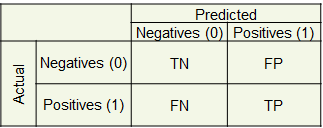

Terms
    1. True Nagatives(TN) - Actual class was 0(False) and Predicted class is also 0 (False) 
    2. False Positives(FP) - Actual class was 0(False) and Predicted class is 1(True) 
    3. False Negatives(FN) - Actual class was 1(True) and Predicted class is 0(False) 
    4. True Positives(TP) - Actual class was 1(True) and Predicted class is also 1 (True)

The following Metrics were considered to decide feature selection for classification

    1. Accuracy  =  (𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝐹𝑃+𝐹𝑁+𝑇𝑁)    (No. of correct predictions/Total predictions)
    2. Precision  =  𝑇𝑃/(𝑇𝑃+𝐹𝑃)      (No. of correct positive predictions/Total positive predictions)
    3. Recall       =  𝑇𝑃/(𝑇𝑃+𝐹𝑁)      (No. of relevant positive predictions/Total actual positives)
    4. F1 Score   =〖2×𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 ×𝑅𝑒𝑐𝑎𝑙𝑙〗∕〖(𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛+𝑅𝑒𝑐𝑎𝑙𝑙)〗
    5. Support   - Number of samples of the true response that lie in each class

## 5. Feature Selection

since the number of features is too large, it has been decided to use ensemble estimators to identify features of importance and eliminate the remaining ones. The estimators use the mean feature importance as a threshold for discarding features.

The subset of features from each of the reduction methods were combined in the end to create a final set of features to be trained against.

### 5.1 Using Extra Trees Classfier

In [44]:
# only use 10 estimators (default) for when we want to run feature selection
xt_clf = ExtraTreesClassifier(n_estimators=10, verbose=2)

In [45]:
xt_clf.fit(X_train, y_train)

building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.2s finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [46]:
prediction = xt_clf.predict(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [47]:
print("Extra Trees Classifier Accuracy Score: %s" % (accuracy_score(y_true=y_test, y_pred=prediction) * 100))
print("Extra Trees Classification Report:")
print(classification_report(y_true=y_test, y_pred=prediction, digits=3))

Extra Trees Classifier Accuracy Score: 99.38333333333334
Extra Trees Classification Report:
             precision    recall  f1-score   support

          0      0.994     1.000     0.997     29816
          1      0.000     0.000     0.000       184

avg / total      0.988     0.994     0.991     30000



In [48]:
#Finding the important features that contribute to the prediction
xt_feat_imp = pd.DataFrame(list(zip(features, xt_clf.feature_importances_)), columns=["feature", "importance"])

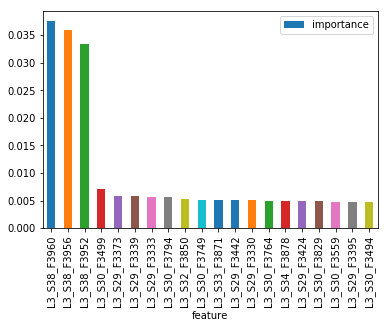

In [49]:
# plot top 20 features
xt_feat_imp.sort_values(by="importance", ascending=False)[:20].plot(y="importance", x="feature", kind="bar")

In [50]:
# use pre-written feature selection methods to determine 
xt_sfm = SelectFromModel(xt_clf, prefit=True)

In [51]:
xt_sfm_support = xt_sfm.get_support()

In [52]:
xt_sfm_features = list(map(lambda y: y[1], filter(lambda x: xt_sfm_support[x[0]], enumerate(features))))

In [53]:
print(len(xt_sfm_features))

281


### 5.2 Using Random Forest Classfier

In [54]:
rfc_clf = RandomForestClassifier(n_estimators=10, verbose=2)

In [55]:
rfc_clf.fit(X_train, y_train)

building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.6s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [56]:
prediction = rfc_clf.predict(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [57]:
print("Random Forest Classifier Accuracy Score: %s" % (accuracy_score(y_true=y_test, y_pred=prediction) * 100))
print("Random Forest Classification Report:")
print(classification_report(y_true=y_test, y_pred=prediction, digits=3))

Random Forest Classifier Accuracy Score: 99.39333333333333
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.994     1.000     0.997     29816
          1      0.600     0.033     0.062       184

avg / total      0.992     0.994     0.991     30000



In [58]:
#Finding the important features that contribute to the prediction
rf_feat_imp = pd.DataFrame(list(zip(features, rfc_clf.feature_importances_)), columns=["feature", "importance"])

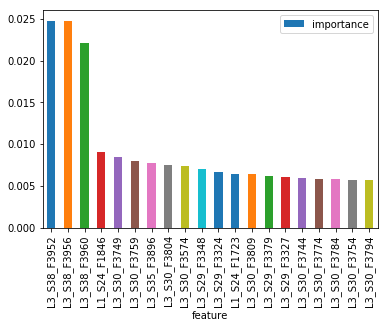

In [59]:
# plot top 20 features based on random forest results
rf_feat_imp.sort_values(by="importance", ascending=False)[:20].plot(y="importance", x="feature", kind="bar")

In [60]:
rf_sfm = SelectFromModel(rfc_clf, prefit=True)

In [61]:
rf_sfm_support = rf_sfm.get_support()

In [62]:
rf_sfm_features = list(map(lambda y: y[1], filter(lambda x: rf_sfm_support[x[0]], enumerate(features))))

In [63]:
print(len(rf_sfm_features))

275


### 5.3 Using Gradient Boosting Machine Classifier

In [65]:
gb_clf = GradientBoostingClassifier(n_estimators=10, verbose=2)

In [66]:
gb_clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0654           19.26s
         2           0.0650           15.44s
         3           0.0643           13.37s
         4           0.0626           11.22s
         5           0.0620            9.23s
         6           0.0617            7.14s
         7           0.0614            5.27s
         8           0.0609            3.50s
         9           0.0607            1.72s
        10           0.0606            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=2,
              warm_start=False)

In [67]:
prediction = gb_clf.predict(X_test)

In [68]:
print("Gradient Boost Accuracy Score: %s" % (accuracy_score(y_true=y_test, y_pred=prediction) * 100))
print("Gradient Boost Classification Report:")
print(classification_report(y_true=y_test, y_pred=prediction, digits=3))

Gradient Boost Accuracy Score: 99.35666666666667
Gradient Boost Classification Report:
             precision    recall  f1-score   support

          0      0.994     0.999     0.997     29816
          1      0.304     0.038     0.068       184

avg / total      0.990     0.994     0.991     30000



In [69]:
#Finding the important features that contribute to the prediction
gb_feat_imp = pd.DataFrame(list(zip(features, gb_clf.feature_importances_)), columns=["feature", "importance"])

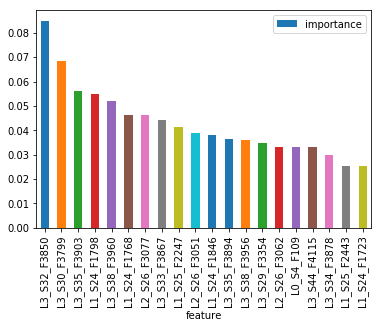

In [70]:
# plot importance for top 20 features as determined by gbm
gb_feat_imp.sort_values(by="importance", ascending=False)[:20].plot(y="importance", x="feature", kind="bar")

In [71]:
gb_sfm = SelectFromModel(gb_clf, prefit=True)

In [72]:
gb_sfm_support = gb_sfm.get_support()

In [73]:
gb_sfm_features = list(map(lambda y: y[1], filter(lambda x: gb_sfm_support[x[0]], enumerate(features))))

In [74]:
print(len(gb_sfm_features))

30


### 5.4 Combining the contributing features from three models

In [76]:
features_iter = list(set(xt_sfm_features + rf_sfm_features + gb_sfm_features))

In [77]:
len(features_iter)

337

In [78]:
# output merged features to csv
pd.DataFrame(features_iter, columns=["features"]).to_csv("ensemble_sfm_features.csv")

In [79]:
# merged feature importance dataframes and output to csv
merged_feat_imp = xt_feat_imp.merge(rf_feat_imp, on="feature", copy=False, suffixes=("_xt", "_rf"), how="outer")

In [80]:
merged_feat_imp = merged_feat_imp.merge(gb_feat_imp, on="feature", copy=False, how="outer")

In [81]:
merged_feat_imp.columns = ["feature", "importance_xt", "importance_rf", "importance_gb"]

In [82]:
merged_feat_imp.to_csv("ensemble_merged_feat_rank.csv")

## 6. Model Training and Inference

With the newly generated feature subset, Different models were used for training and inference. 

### 6.1 Create new Independent Train and test data  

In [83]:
X_new = df_numeric_mean[features_iter].values

In [84]:
X_new_train = X_new[:int(0.7*len(X_new))]
X_new_test = X_new[int(0.7*len(X_new)):]

In [90]:
class_names = ["0", "1"]

### 6.2 Training and Inference Using Gradient Boosting Classifier

In [94]:
gb_clf = GradientBoostingClassifier(n_estimators=25, verbose=2)

In [86]:
gb_clf.fit(X_new_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0654           19.98s
         2           0.0650           17.74s
         3           0.0643           16.58s
         4           0.0626           16.11s
         5           0.0620           15.69s
         6           0.0619           14.74s
         7           0.0616           13.94s
         8           0.0606           13.23s
         9           0.0603           12.47s
        10           0.0600           11.64s
        11           0.0599           10.92s
        12           0.0599           10.25s
        13           0.0599            9.52s
        14           0.0598            8.99s
        15           0.0598            8.21s
        16           0.0595            7.39s
        17           0.0595            6.58s
        18           0.0594            5.78s
        19           0.0594            4.96s
        20           0.0593            4.15s
        21           0.0592            3.32s
        2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=25,
              presort='auto', random_state=None, subsample=1.0, verbose=2,
              warm_start=False)

In [87]:
# Inference using test data
prediction_gb = gb_clf.predict(X_new_test)

#### Plot the confusion Matrix

In [88]:
df_confusion = confusion_matrix(y_true=y_test, y_pred=prediction_gb)

[[29801    15]
 [  177     7]]


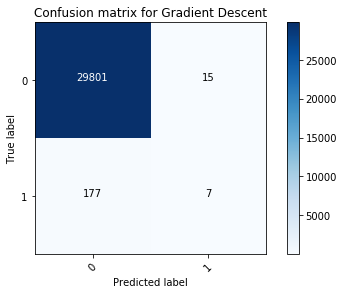

In [91]:
plt.figure()
plot_confusion_matrix(df_confusion, classes=class_names,
                      title='Confusion matrix for Gradient Descent')

#### Print the Metrics for the Gradient Boosting Classifier

In [71]:
print("Gradient Boost Accuracy Score: %s" % (accuracy_score(y_true=y_test, y_pred=prediction_gb) * 100))
print("Gradient Boost Classification Report:")
print(classification_report(y_true=y_test, y_pred=prediction_gb, digits=3))

Gradient Boost Accuracy Score: 99.35000000000001
Gradient Boost Classification Report:
             precision    recall  f1-score   support

          0      0.994     0.999     0.997     29816
          1      0.310     0.049     0.085       184

avg / total      0.990     0.994     0.991     30000



#### Plot the Receiver Operating Characteristic (ROC) Curve

An ROC curve is a graph showing the performance of a classification model at all  classification thresholds. This curve plots two parameters:
   
- True Positive Rate (TPR)   = TP/(TP+FN)

- False Positive Rate (FPR)  = FP / FP + FN

ROC curve is used for visual comparison of classification models which shows the trade-off between the true positive rate and the false positive rate. 

The area under the curve(AUC) in the plotted ROC curve is a measure of accuracy of the model.

When a model is closer to the diagonal, it is less accurate and the model with perfect accuracy will have an area of 1.0

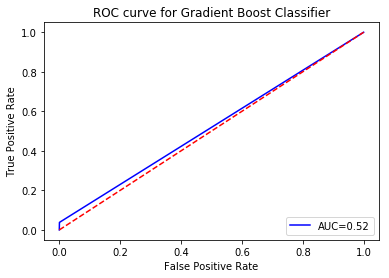

In [93]:
plot_roc_curve('Gradient Boost Classifier', y_test, prediction_gb)

### 6.3 Training and Inference Using Linear Support Vector Machine  Classifier(SVC) 

In [95]:
lsvm = LinearSVC(verbose=2)

In [96]:
lsvm.fit(X_new_train, y_train)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=2)

In [97]:
#Inference using the test data
prediction_svm = lsvm.predict(X_new_test)

#### Plot the confusion Matrix

In [98]:
df_confusion = confusion_matrix(y_true=y_test, y_pred=prediction_svm)

[[29815     1]
 [  183     1]]


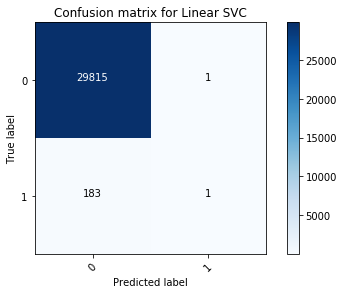

In [108]:
plt.figure()
plot_confusion_matrix(df_confusion, classes=class_names,
                      title='Confusion matrix for Linear SVC')

#### Print the Metrics for the Linear SVC

In [101]:
print("LinearSVC Accuracy Score: %s" % (accuracy_score(y_true=y_test, y_pred=prediction_svm) * 100))
print("LinearSVC Classification Report:")
print(classification_report(y_true=y_test, y_pred=prediction_svm, digits=3))

LinearSVC Accuracy Score: 99.38666666666667
LinearSVC Classification Report:
             precision    recall  f1-score   support

          0      0.994     1.000     0.997     29816
          1      0.500     0.005     0.011       184

avg / total      0.991     0.994     0.991     30000



#### Plot the Receiver Operating Characteristic (ROC) Curve

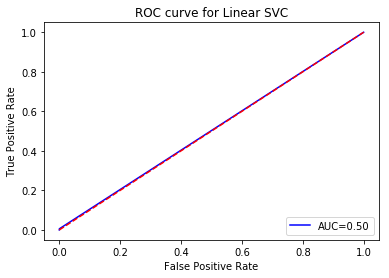

In [103]:
plot_roc_curve('Linear SVC', y_test, prediction_svm)

### 6.4 Training and Inference Using Random Forest  Classifier 

In [105]:
rf_clf = RandomForestClassifier(n_estimators=25, verbose=2, oob_score=True)

In [106]:
rf_clf.fit(X_new_train, y_train)

building tree 1 of 25


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   27.5s finished
C:\Users\rnidamax\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\rnidamax\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=True, random_state=None, verbose=2, warm_start=False)

In [107]:
# Inference using the test data
prediction_rf = rf_clf.predict(X_new_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


#### Plot the confusion Matrix

In [109]:
df_confusion = confusion_matrix(y_true=y_test, y_pred=prediction_rf)

[[29812     4]
 [  179     5]]


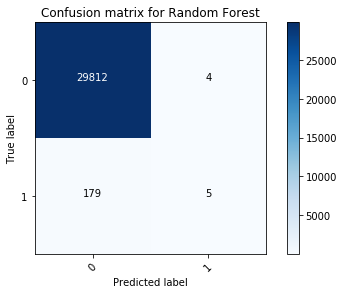

In [110]:
class_names = ["0", "1"]
plt.figure()
plot_confusion_matrix(df_confusion, classes=class_names,
                      title='Confusion matrix for Random Forest')

#### Print the Metrics for the Random Forest

In [111]:
print("Random Forest Accuracy Score: %s" % (accuracy_score(y_true=y_test, y_pred=prediction_rf) * 100))
print("Random Forest Classification Report:")
print(classification_report(y_true=y_test, y_pred=prediction_rf, digits=3))

Random Forest Accuracy Score: 99.39
Random Forest Classification Report:
             precision    recall  f1-score   support

          0      0.994     1.000     0.997     29816
          1      0.556     0.027     0.052       184

avg / total      0.991     0.994     0.991     30000



#### Plot the Receiver Operating Characteristic (ROC) Curve

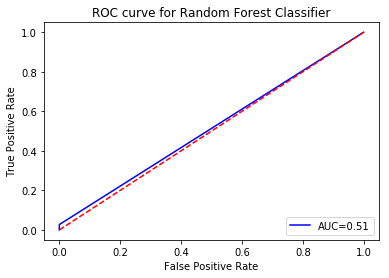

In [112]:
plot_roc_curve('Random Forest Classifier', y_test, prediction_rf)

## 7. Conclusion
Using the Bosch Production Line performance data set, With a selectivly generated feature subset, three different models were used for training and evaluation. Of the two ensemble (GradientBoost, RandomForest) and SVM (LinearSVC) estimators, the Random Forest Classifier training resulted in the highest precision and Recall (i.e. small number of false negatives) 

<br>